# Import Libraries

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import math
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
from operator import itemgetter
from math import log
import matplotlib.pyplot as plt
%matplotlib inline

# Load data set

#### Once loaded,we could convert the txt data to a NumPy array.

In [2]:
def loadDataset(infile):
    df = pd.read_csv(infile, sep='\t', header=None, dtype=str, na_filter=False)
    return np.array(df).astype(np.float)

# Choose Number of Clusters
#### Implemented Elbow Method to find the optimal k, that is to repeatedly run k-means clustering on the dataset for a range of values of k, and for each value of k calculate the sum of squared errors (SSE). Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best.   

In [3]:
def elbow(data):
    SSE=[]
    k_vals=[2,3,4,5,6,7,8,9,10,11]
    for k in k_vals:
        model=KMeans(n_clusters=k,max_iter=500, n_init=10)
        model.fit(data)
        SSE.append(model.inertia_)
        
    X = range(2,12)
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.plot(X,SSE,'o-')
    plt.grid(True, linestyle = "-", linewidth = "1")
    plt.title("SSE of different k values")
    my_x_ticks = np.arange(2, 12, 1)
    plt.xticks(my_x_ticks)
    plt.show()

## We choose k=5.

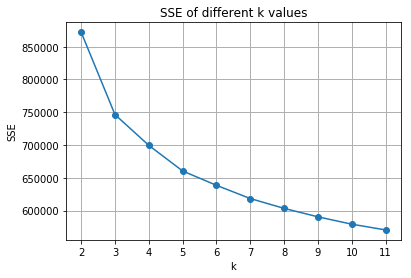

In [4]:
a=loadDataset("ticdata2000.txt")
elbow(a)

# First Experiment(a)
#### Here I directly use the most 21 informative attributes mentioned in the paper to run k-means clustering, using sklearn.Kmeans.

In [6]:
col1=[0,4,15,18,24,29,30,31,33,34,36,38,41,42,43,46,58,60,64,67,81]
X1=a[:,col1]
model1 =KMeans(n_clusters=5, max_iter=300, n_init=10)
t0 = time.time()
model1.fit(X1)
t_batch_1 = time.time() - t0
y_pred1=model1.predict(X1)
print(metrics.calinski_harabaz_score(X1, y_pred1))
print(t_batch_1)

[4 4 0 ... 0 4 0]
5109.501200376611


#### The centroids table is as follows:

In [113]:
#Centroid Table
features=["1-MOSTYPE","5-MOSHOOFD","16-MOPLHOOG","19-MBERHOOG","25-MSKA",
          "30-MHHUUR","31-MHKOOP","32-MAUT1","34-MAUT0","35-MZFONDS","37-MINKM30",
          "39-MINK4575","42-MINKGEM","43-MKOOPKLA","44-PWAPART","47-PPERSAUT","59-PBRAND",
          "61-PPLEZIER","65-AWAPART","68-APERSAUT","82-APLEZIER"]
clus1=model1.cluster_centers_
clustroids1 = pd.DataFrame(clus1.T,index=features,columns='Cluster_0 Cluster_1 Cluster_2 Cluster_3 Cluster_4'.split())
clustroids1.round(3)

Cluster_0  Cluster_1  Cluster_2  Cluster_3  Cluster_4
1-MOSTYPE       34.165      8.466     23.403      7.081     35.704
5-MOSHOOFD       7.933      2.440      5.192      2.022      8.413
16-MOPLHOOG      0.539      1.792      1.449      2.931      0.976
19-MBERHOOG      0.911      2.014      1.451      3.551      1.607
25-MSKA          0.639      1.648      1.226      3.158      1.425
30-MHHUUR        7.153      6.323      6.955      1.163      2.249
31-MHKOOP        1.857      2.689      2.055      7.846      6.756
32-MAUT1         5.693      6.318      5.284      6.776      6.013
34-MAUT0         2.547      1.940      3.277      0.988      1.624
35-MZFONDS       7.483      6.129      6.934      4.634      6.320
37-MINKM30       3.942      2.689      3.972      1.106      1.946
39-MINK4575      1.586      2.682      1.974      4.114      2.947
42-MINKGEM       2.921      3.696      3.078      4.935      3.955
43-MKOOPKLA      3.067      5.540      2.112      6.777      3.766
44-PWAPART       0.711      0.682      0.951      0.855      0.710
47-PPERSAUT      3.083      2.922      2.651      3.118      2.956
59-PBRAND        1.546      1.553      1.288      2.210      2.116
61-PPLEZIER      0.012      0.019      0.015      0.027      0.020
65-AWAPART       0.382      0.355      0.495      0.439      0.371
68-APERSAUT      0.577      0.558      0.492      0.592      0.565
82-APLEZIER      0.004      0.004      0.005      0.010      0.006

# First Experiment(b)
#### In this part, I implemented feature selection by calculating the shannon entropy of each feature.

In [8]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet) 
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]   
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1  
    shannonEnt = 0.0
    for key in labelCounts:  
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) 
    return shannonEnt
    
def splitDataSet(data,feature,value):
    #return splitted data
    newdata=[]
    for rows in data:
        if rows[feature]==value : 
            reduceFeatVec=rows[:feature]
            reduceFeatVec.extend(rows[feature+1:])
            newdata.append(reduceFeatVec)
    return newdata 

def rankFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1  
    baseEntropy = calcShannonEnt(dataSet)   
    bestInfoGain = 0.0; 
    rankFeature = dict()
    for i in range(numFeatures):   
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:  
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy  
        rankFeature[i]=rankFeature.setdefault(i,0)+infoGain
    return rankFeature

In [9]:
label=[]
for i in range(86):
    label.append("feature"+str(i+1))
data=a.tolist()
rank=rankFeatureToSplit(data)
rank=sorted(rank.items(), key=itemgetter(1), reverse=True)[0:21]
col2=[]
for i in range(21):
    col2.append(rank[i][0])
col2.sort()
print(col2)

[0, 4, 9, 15, 17, 24, 29, 30, 31, 33, 36, 38, 41, 42, 43, 46, 58, 60, 64, 67, 79]


In [10]:
X2=a[:,col2]
model2 =KMeans(n_clusters=5, max_iter=300, n_init=10)
t0 = time.time()
model2.fit(X2)
t_batch_2 = time.time() - t0
y_pred2=model2.predict(X2)
print(metrics.calinski_harabaz_score(X2, y_pred2))

5042.39057522033


#### The centroids table is as follows:

In [11]:
features=["1-MOSTYPE","5-MOSHOOFD","10-MRELGE","16-MOPLHOOG","18-MOPLLAAG","25-MSKA",
          "30-MHHUUR","31-MHKOOP","32-MAUT1","34-MAUT0","37-MINKM30",
          "39-MINK4575","42-MINKGEM","43-MKOOPKLA","44-PWAPART","47-PPERSAUT","59-PBRAND",
          "61-PPLEZIER","65-AWAPART","68-APERSAUT","80-ABRAND"]
clus2=model2.cluster_centers_
clustroids2 = pd.DataFrame(clus2.T,index=features,columns='Cluster_0 Cluster_1 Cluster_2 Cluster_3 Cluster_4'.split())
clustroids2.round(3)

Cluster_0  Cluster_1  Cluster_2  Cluster_3  Cluster_4
1-MOSTYPE        7.193     34.292      8.208     23.422     35.668
5-MOSHOOFD       2.050      7.960      2.375      5.207      8.407
10-MRELGE        7.188      5.895      6.146      4.052      6.720
16-MOPLHOOG      2.923      0.560      1.819      1.446      0.970
18-MOPLLAAG      2.492      6.365      3.523      4.415      5.214
25-MSKA          3.127      0.687      1.722      1.233      1.403
30-MHHUUR        1.112      7.118      6.312      6.922      2.200
31-MHKOOP        7.899      1.893      2.699      2.088      6.805
32-MAUT1         6.802      5.657      6.300      5.279      6.046
34-MAUT0         0.970      2.564      1.936      3.279      1.593
37-MINKM30       1.068      3.929      2.718      3.983      1.912
39-MINK4575      4.140      1.599      2.666      1.976      2.961
42-MINKGEM       4.941      2.922      3.717      3.067      3.976
43-MKOOPKLA      6.799      3.107      5.560      2.119      3.748
44-PWAPART       0.851      0.710      0.691      0.946      0.712
47-PPERSAUT      3.136      3.047      2.917      2.641      2.980
59-PBRAND        2.185      1.552      1.609      1.291      2.122
61-PPLEZIER      0.027      0.012      0.019      0.014      0.020
65-AWAPART       0.437      0.381      0.360      0.492      0.372
68-APERSAUT      0.596      0.571      0.555      0.490      0.569
80-ABRAND        0.620      0.523      0.520      0.550      0.600

# Summary of the First Experiment
#### The result of both of the two models are close to the result in the paper and the calinski harabaz scores are high, which indicates they are good models. There exist slight differences when picking informative features, which is not unsurprising because the paper doesn't specify the feature selection method. It's hard to visualizecluster  due to the hign dimension of the data.

# Clustering Analysis
#### In this part, I analysed the 10 interesting features which are mentioned in the paper.

In [12]:
def caldistance(data,clus_centers,pred):
    real_clus=[]
    for index,row in enumerate(data):
        y=pred[index]
        total_dev=sum(row-clus_centers[y])
        if total_dev>0: sign=1
        else : sign=-1
        dis=total_dev/(2*len(data[0]))
        real_clus.append(dis+y)
    return real_clus


dis=caldistance(X1,clus1,y_pred1)
data_ana=loadDataset("ticdata2000.txt")


In [111]:
def draw1(feat_name,data):
    labels=['0','1']
    clusters='Cluster_0 Cluster_1 Cluster_2 Cluster_3 Cluster_4'.split()
    x_range=list(range(5))
    fig=plt.figure(figsize=(16,8))
    ax = fig.gca()
    ax.grid(True,linestyle='-.')
    plt.xlabel('Cluster',fontsize=14)
    plt.ylabel(feat_name,fontsize=14)
    plt.title(feat_name+' Analysis',fontsize=14)
    plt.xticks(x_range,clusters,rotation = 45)
    #plt.x_axis([-0.5,4.5])
    plt.xlim(-0.5, 4.5)
    plt.axvspan(-0.5,0.5, color='grey', alpha=0.05)
    plt.axvspan(1.5,2.5, color='grey', alpha=0.05)
    plt.axvspan(3.5,4.5, color='grey', alpha=0.05)
    fig=plt.scatter(data[:,2],data[:,0],c=data[:,1],cmap=cm.coolwarm,linewidths=0.5,alpha=0.4)
    cbar=plt.colorbar(fig)
    cbar.ax.set_xlabel('86-CARAVAN')
    plt.show()
    
def draw2(feat_name,df):

    sns.set(font_scale=1.5,style="whitegrid")
    sns.set_context({"figure.figsize":(20,8)})
    x_range=list(range(5))
    plt.title(feat_name+' Analysis',fontsize=14)
    clusters='Cluster_0 Cluster_1 Cluster_2 Cluster_3 Cluster_4'.split()
    sns.stripplot(x="Cluster", y=feat_name, data=df,jitter=True,hue='86-CARAVAN',palette='Set1',dodge=True)
    plt.xticks(x_range,clusters,rotation = 45)
    

def extract_data(ori_data,col_num,dis,ymax):
    data=ori_data[:,[col_num,85]]
    data=np.c_[data,dis]
    for row in data:
        row[0]+=np.random.normal(loc=0.0, scale=ymax/16,size=1)
    return data

def get_data1(data,feat_num,y_pred):
    new_data=data[:,feat_num]
    new_data=np.c_[new_data,y_pred]
    for row in new_data:
        row[0]+=np.random.normal(loc=0.0, scale=0.5,size=1) 
        row[1]+=np.random.normal(loc=0.0, scale=0.3,size=1)
        row[2]+=np.random.normal(loc=0.0, scale=0.5,size=1)
        row[3]+=np.random.normal(loc=0.0, scale=0.5,size=1)
        row[4]+=np.random.normal(loc=0.0, scale=0.5,size=1)
        row[5]+=np.random.normal(loc=0.0, scale=0.5,size=1)
        row[6]+=np.random.normal(loc=0.0, scale=0.5,size=1)
        row[7]+=np.random.normal(loc=0.0, scale=0.125,size=1)
        row[8]+=np.random.normal(loc=0.0, scale=3,size=1)
        row[9]+=np.random.normal(loc=0.0, scale=0.25,size=1)
    return new_data

def get_data2(data,feat_num,y_pred):
    new_data=data[:,feat_num]
    new_data=np.c_[new_data,y_pred]
    return new_data

data_get1=get_data1(data_ana,[46,58,67,4,42,60,41,81,0,43,85],y_pred1)
data_get2=get_data2(data_ana,[46,58,67,4,42,60,41,81,0,43,85],y_pred1)
df1=pd.DataFrame(data_get1,columns=["47-PPERSAUT","59-PBRAND","68-APERSAUT","5-MOSHOOFD","43-MKOOPKLA","61-PPLEZIER",
                                 "42-MINKGEM","82-APLEZIER","1-MOSTYPE","44-PWAPART","86-CARAVAN","Cluster"])
df2=pd.DataFrame(data_get2,columns=["47-PPERSAUT","59-PBRAND","68-APERSAUT","5-MOSHOOFD","43-MKOOPKLA","61-PPLEZIER",
                                 "42-MINKGEM","82-APLEZIER","1-MOSTYPE","44-PWAPART","86-CARAVAN","Cluster"])
df2.groupby('Cluster').mean()


47-PPERSAUT  59-PBRAND  68-APERSAUT  5-MOSHOOFD  43-MKOOPKLA  \
Cluster                                                                 
0.0         3.083467   1.545746     0.577047    7.932584     3.066613   
1.0         2.922330   1.553398     0.557559    2.439667     5.539528   
2.0         2.650794   1.288156     0.492063    5.191697     2.112332   
3.0         3.118464   2.209967     0.592320    2.022059     6.776961   
4.0         2.956402   2.116446     0.565121    8.412804     3.766004   

         61-PPLEZIER  42-MINKGEM  82-APLEZIER  1-MOSTYPE  44-PWAPART  \
Cluster                                                                
0.0         0.012039    2.921348     0.004013  34.165329    0.711075   
1.0         0.019417    3.696255     0.004161   8.466019    0.682386   
2.0         0.014652    3.078144     0.004884  23.402930    0.951160   
3.0         0.026961    4.935458     0.009804   7.080882    0.854575   
4.0         0.019868    3.954746     0.006071  35.703642    0.710265   

         86-CARAVAN  
Cluster              
0.0        0.043339  
1.0        0.056865  
2.0        0.023199  
3.0        0.107843  
4.0        0.056291

In [114]:
df2.groupby(['Cluster','86-CARAVAN']).mean()

47-PPERSAUT  59-PBRAND  68-APERSAUT  5-MOSHOOFD  \
Cluster 86-CARAVAN                                                    
0.0     0.0            3.008389   1.526007     0.561242    7.931208   
        1.0            4.740741   1.981481     0.925926    7.962963   
1.0     0.0            2.817647   1.500000     0.536765    2.457353   
        1.0            4.658537   2.439024     0.902439    2.146341   
2.0     0.0            2.580000   1.271250     0.480000    5.191250   
        1.0            5.631579   2.000000     1.000000    5.210526   
3.0     0.0            2.909341   2.122711     0.552198    2.020147   
        1.0            4.848485   2.931818     0.924242    2.037879   
4.0     0.0            2.870760   2.097076     0.547368    8.417544   
        1.0            4.392157   2.441176     0.862745    8.333333   

                    43-MKOOPKLA  61-PPLEZIER  42-MINKGEM  82-APLEZIER  \
Cluster 86-CARAVAN                                                      
0.0     0.0            3.070470     0.012584    2.915268     0.004195   
        1.0            2.981481     0.000000    3.055556     0.000000   
1.0     0.0            5.526471     0.020588    3.688235     0.004412   
        1.0            5.756098     0.000000    3.829268     0.000000   
2.0     0.0            2.115000     0.005000    3.068750     0.001250   
        1.0            2.000000     0.421053    3.473684     0.157895   
3.0     0.0            6.763736     0.023810    4.915751     0.008242   
        1.0            6.886364     0.053030    5.098485     0.022727   
4.0     0.0            3.759064     0.005848    3.945029     0.001754   
        1.0            3.882353     0.254902    4.117647     0.078431   

                    1-MOSTYPE  44-PWAPART  
Cluster 86-CARAVAN                         
0.0     0.0         34.166107    0.694631  
        1.0         34.148148    1.074074  
1.0     0.0          8.514706    0.664706  
        1.0          7.658537    0.975610  
2.0     0.0         23.405000    0.951250  
        1.0         23.315789    0.947368  
3.0     0.0          7.054945    0.798535  
        1.0          7.295455    1.318182  
4.0     0.0         35.701170    0.690643  
        1.0         35.745098    1.039216

#### Feature 47 PRERSAUT

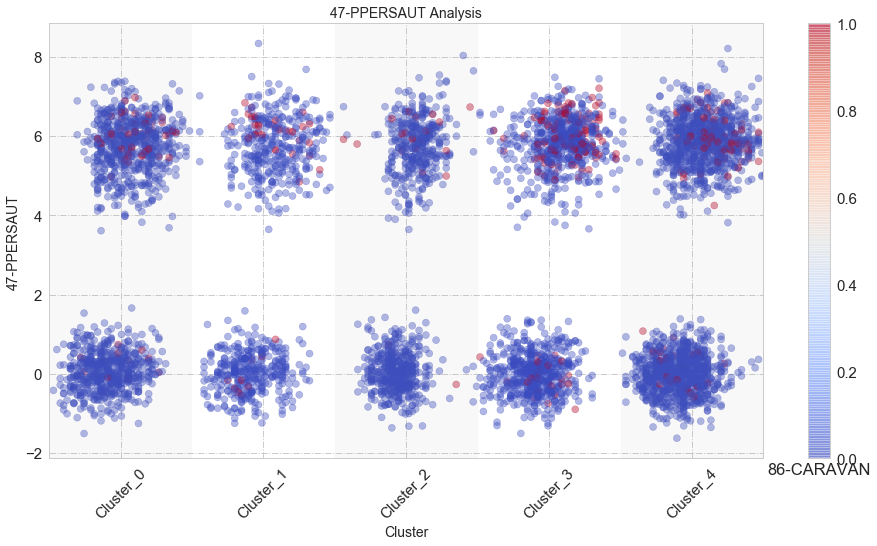

In [54]:
data_47=extract_data(data_ana,46,dis,8)
draw1("47-PPERSAUT",data_47)

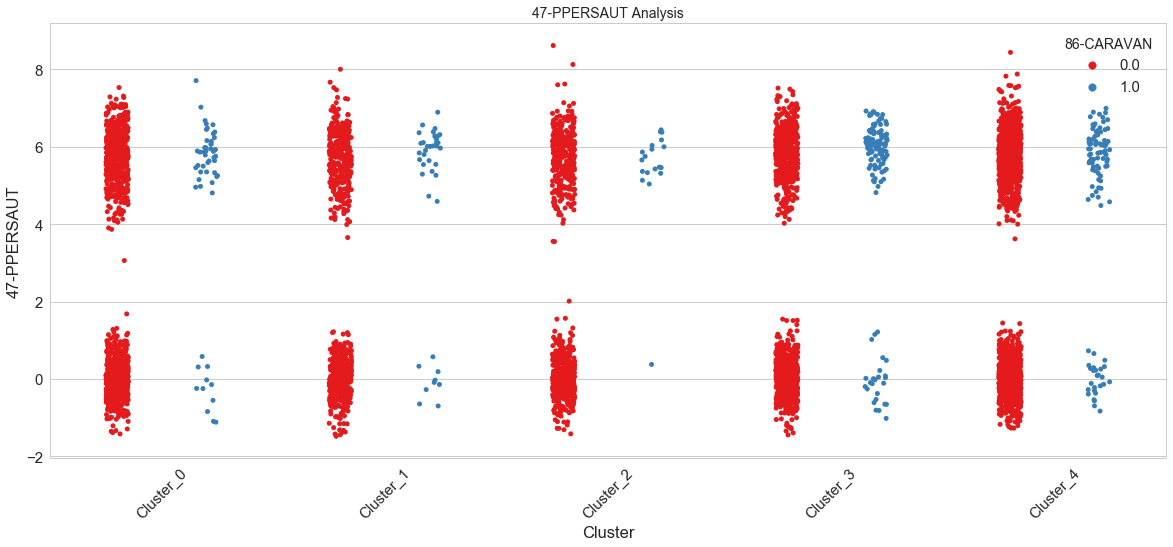

In [90]:
draw2("47-PPERSAUT",df1)

#### Feature 59 PBRAND

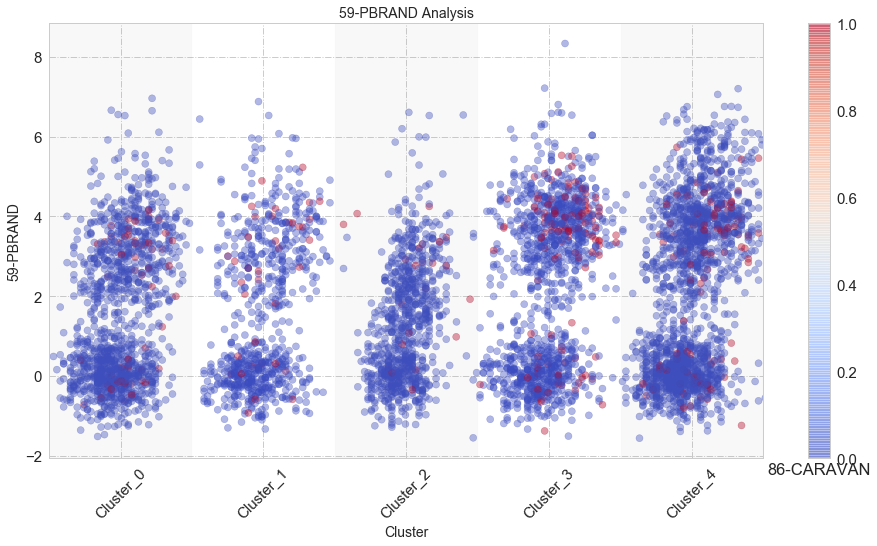

In [56]:
data_59=extract_data(data_ana,58,dis,8)
draw1("59-PBRAND",data_59)

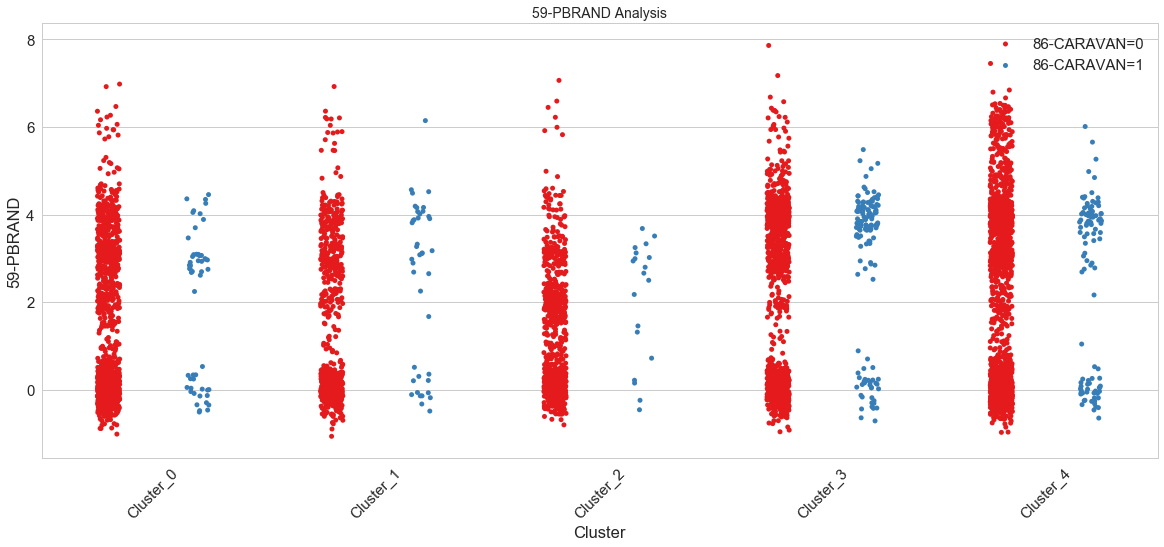

In [78]:
draw2("59-PBRAND",df1)

##### Feature 68 APERSAUT

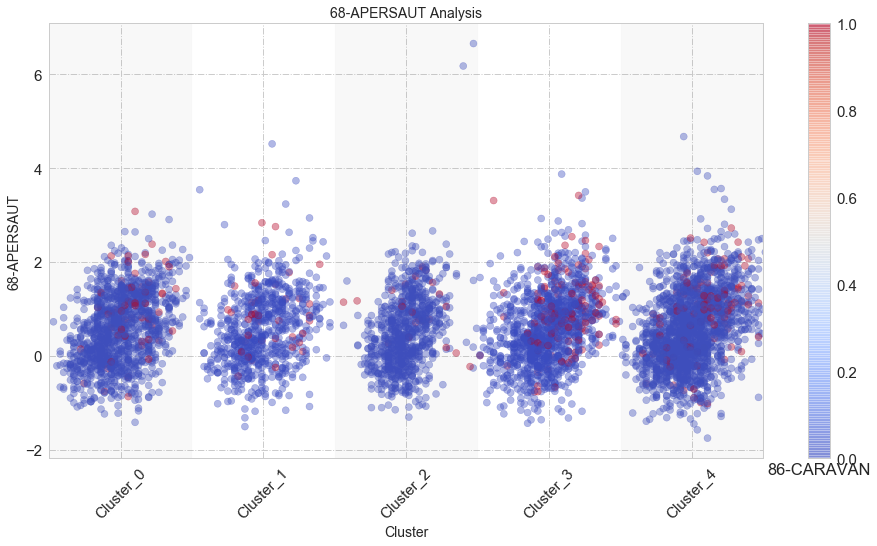

In [58]:
data_68=extract_data(data_ana,67,dis,8)
draw1("68-APERSAUT",data_68)

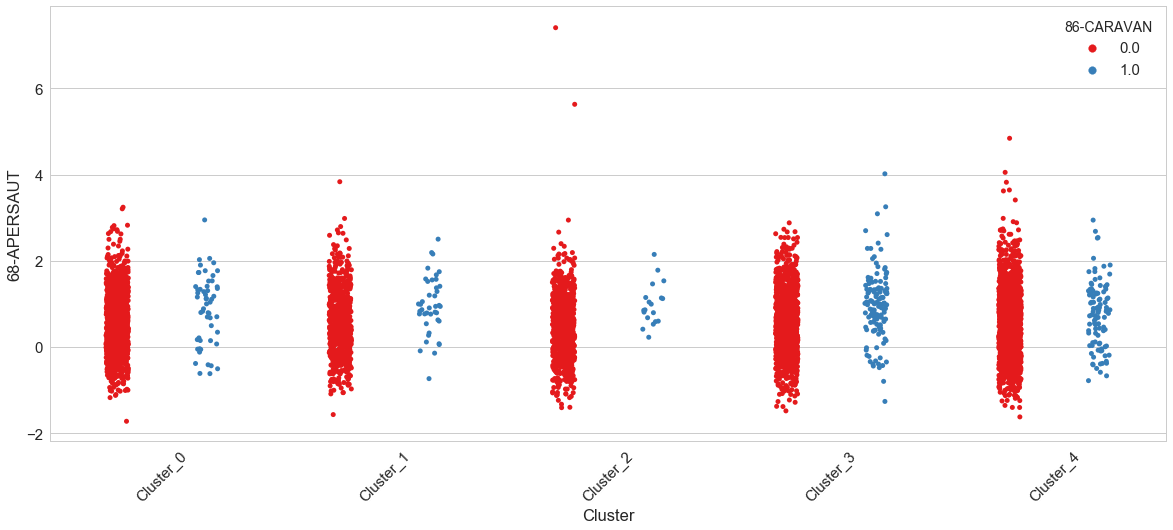

In [59]:
draw2("68-APERSAUT",df1)

##### Feature 5 MOSHOOFD

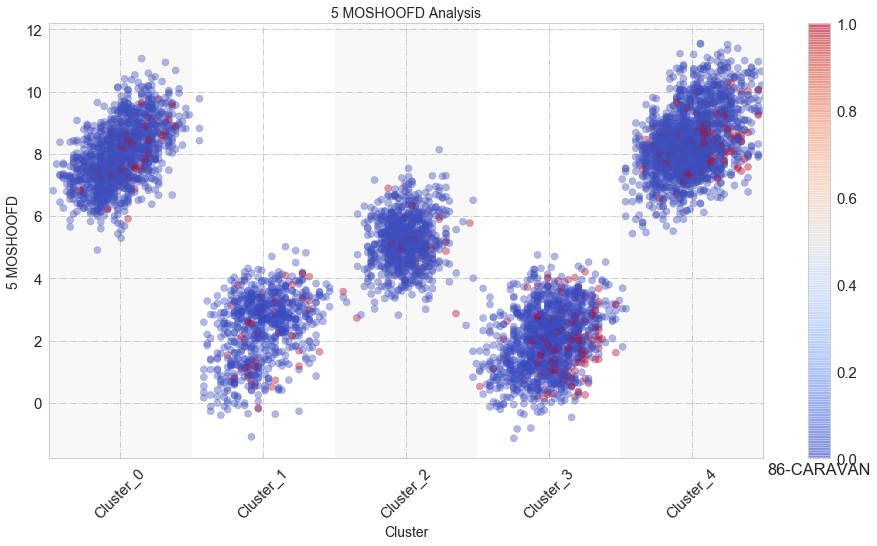

In [60]:
data_5=extract_data(data_ana,4,dis,10)
draw1("5 MOSHOOFD",data_5)

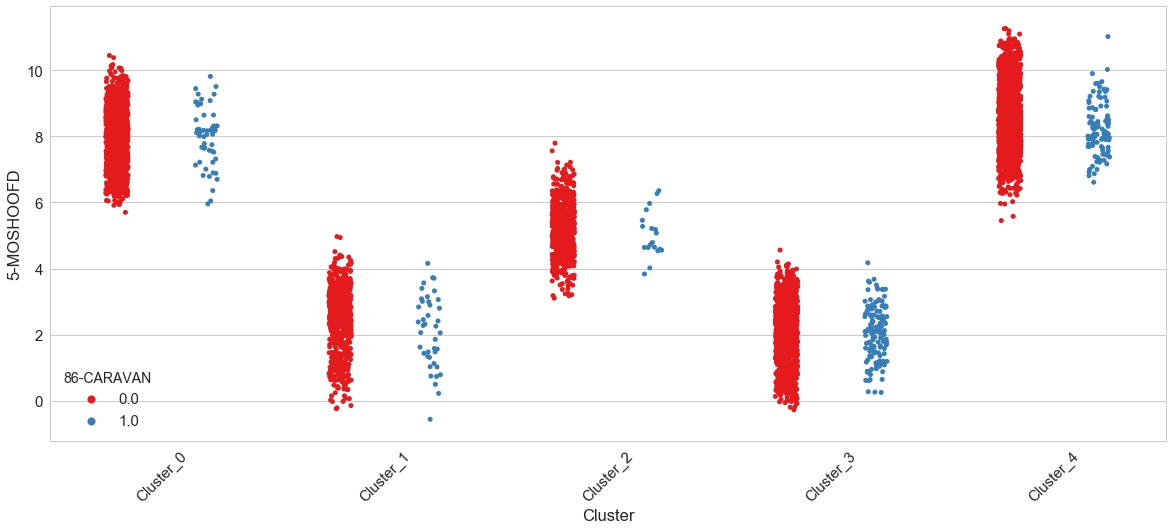

In [61]:
draw2("5-MOSHOOFD",df1)

#### Feature 43 MKOOPKLA

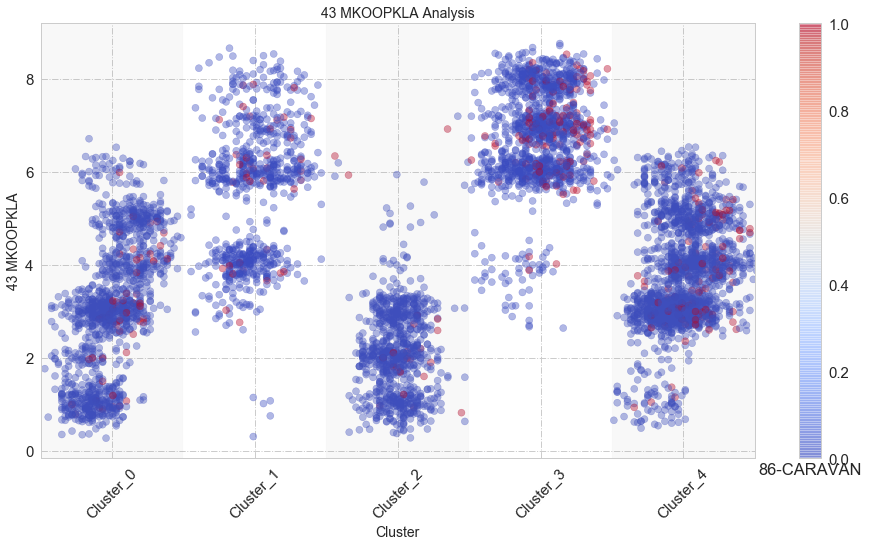

In [62]:
data_43=extract_data(data_ana,42,dis,4)
draw1("43 MKOOPKLA",data_43)

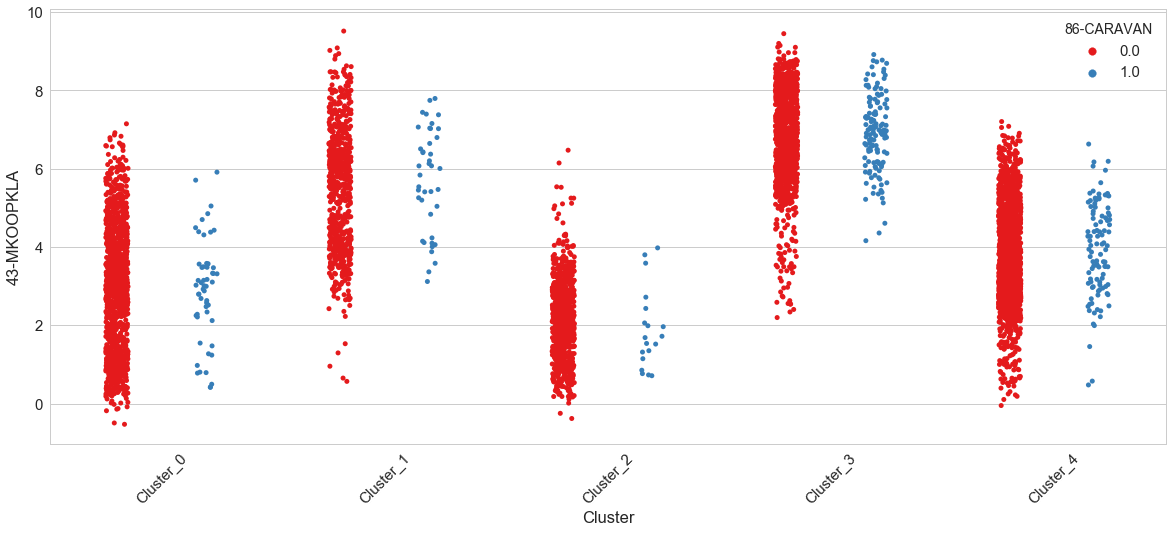

In [63]:
draw2("43-MKOOPKLA",df)

#### Feature 61 PPLEZIER

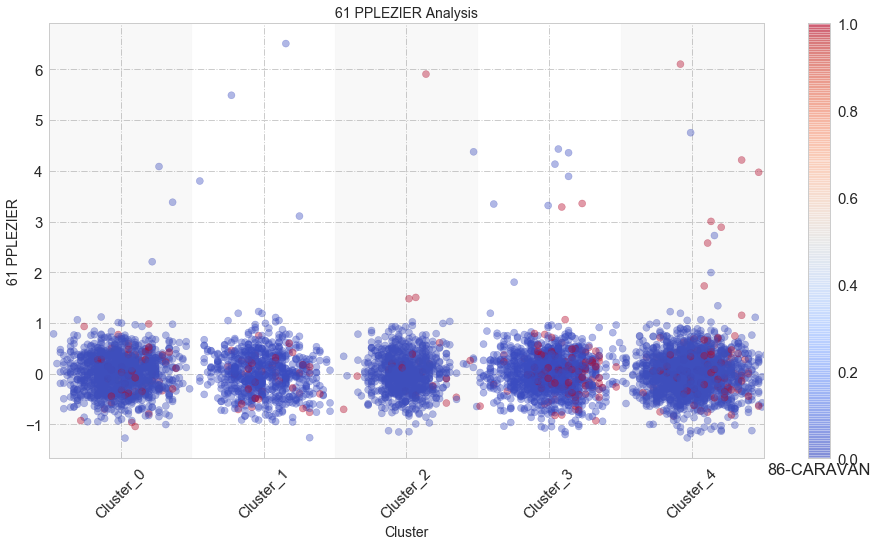

In [64]:
data_61=extract_data(data_ana,60,dis,6)
draw1("61 PPLEZIER",data_61)

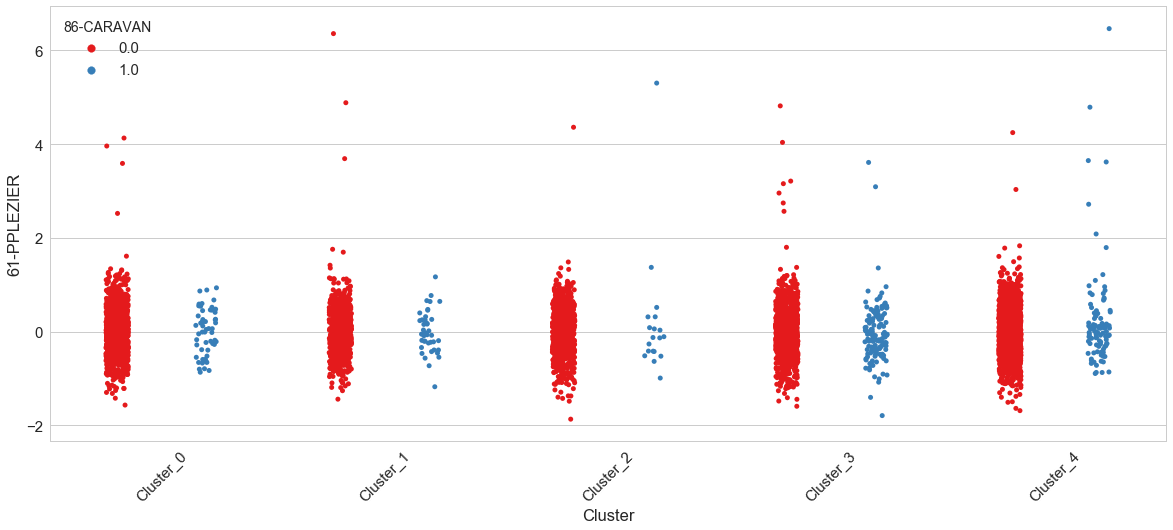

In [65]:
draw2("61-PPLEZIER",df1)

#### Feature 42 MINKGEM

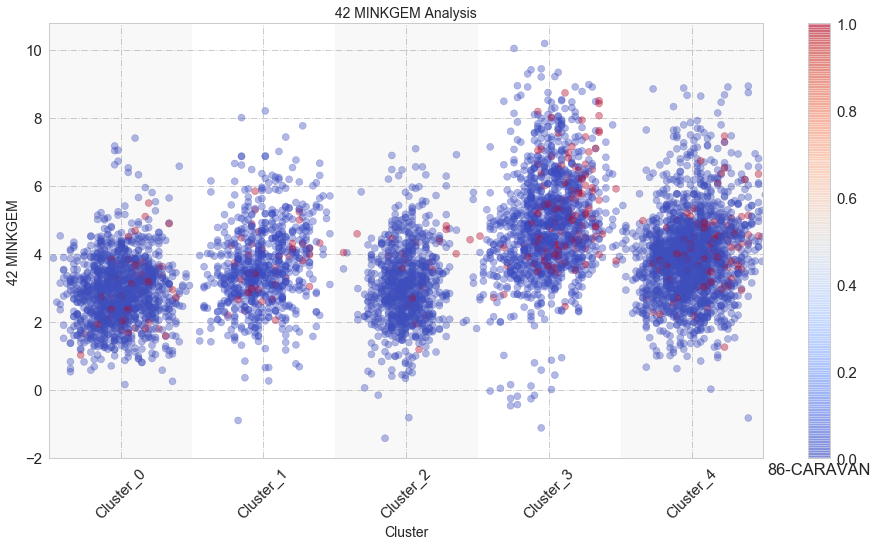

In [66]:
data_42=extract_data(data_ana,41,dis,9)
draw1("42 MINKGEM",data_42)

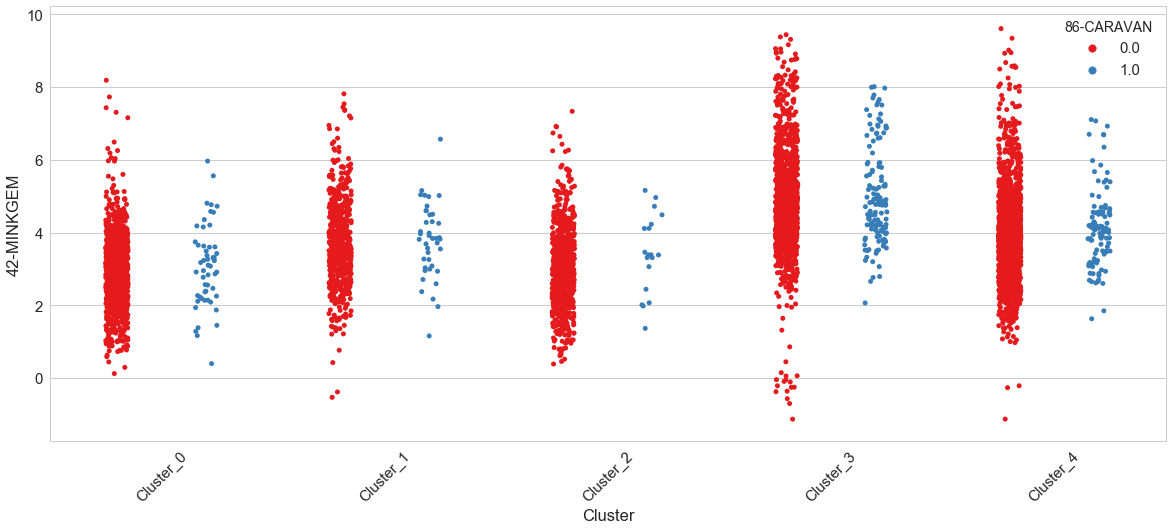

In [67]:
draw2("42-MINKGEM",df1)

#### Feature 82 APLEZIER

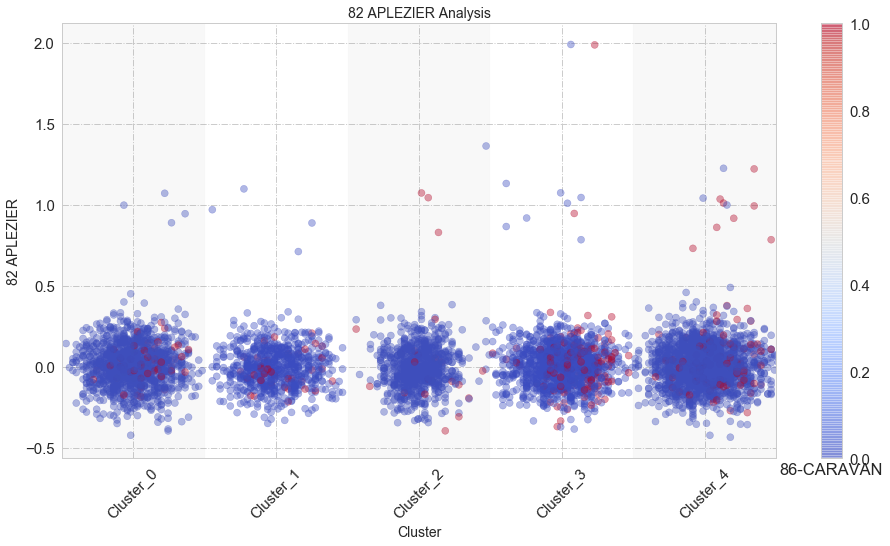

In [68]:
data_82=extract_data(data_ana,81,dis,2)
draw1("82 APLEZIER",data_82)

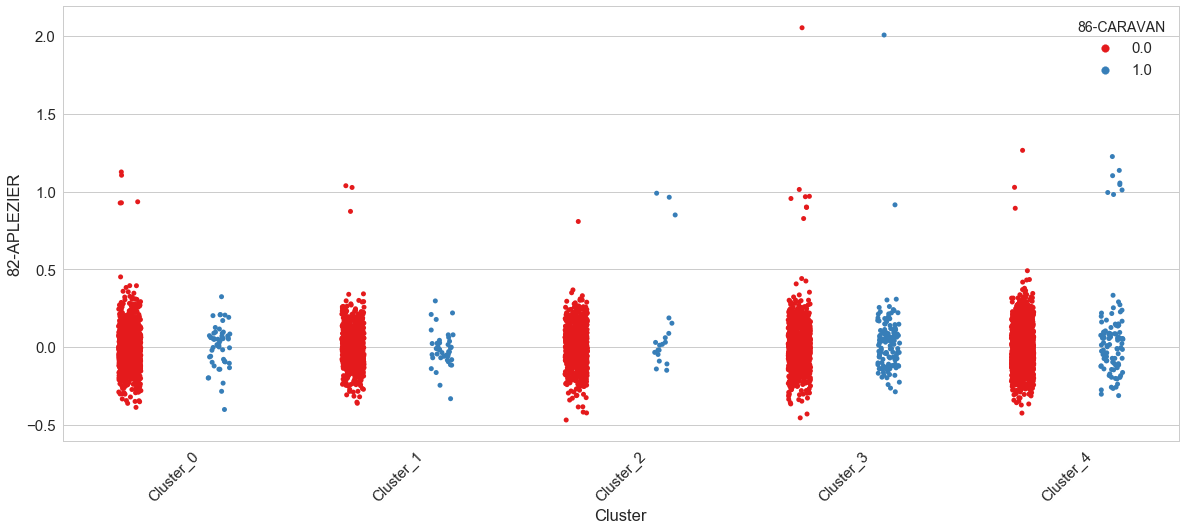

In [69]:
draw2("82-APLEZIER",df1)

#### Feature 1 MOSTYPE

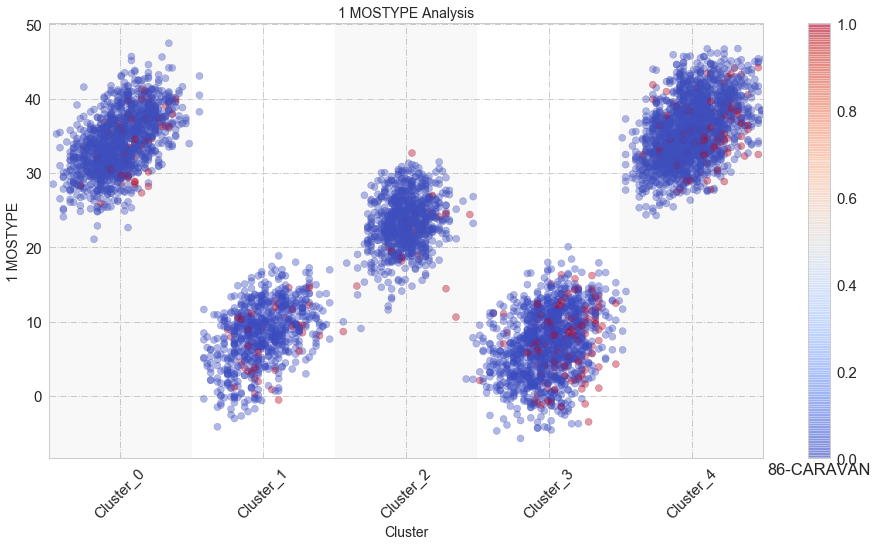

In [70]:
data_1=extract_data(data_ana,0,dis,41)
draw1("1 MOSTYPE",data_1)

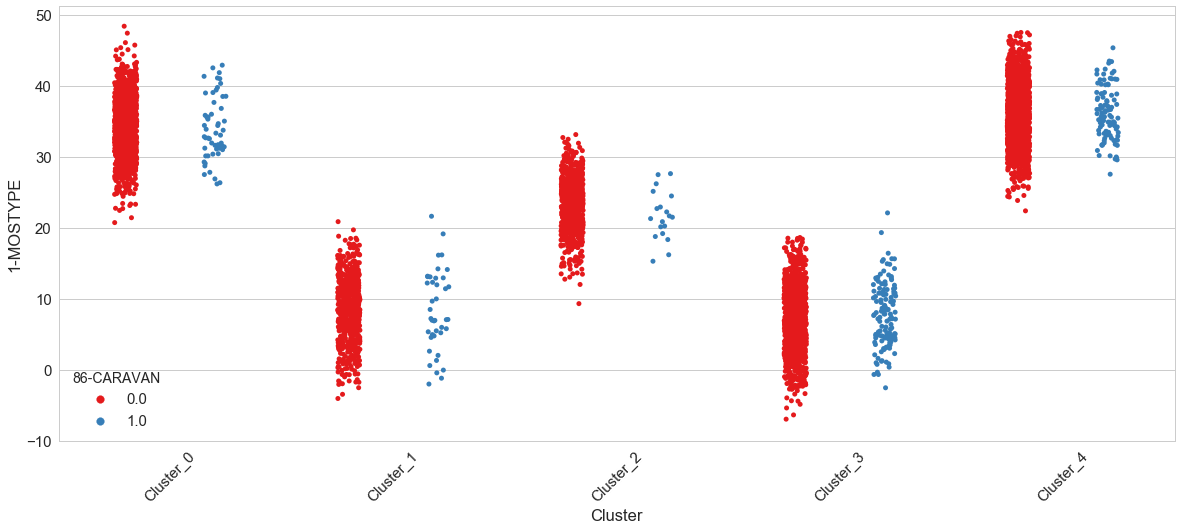

In [71]:
draw2("1-MOSTYPE",df1)

#### Feature 44 PWAPART

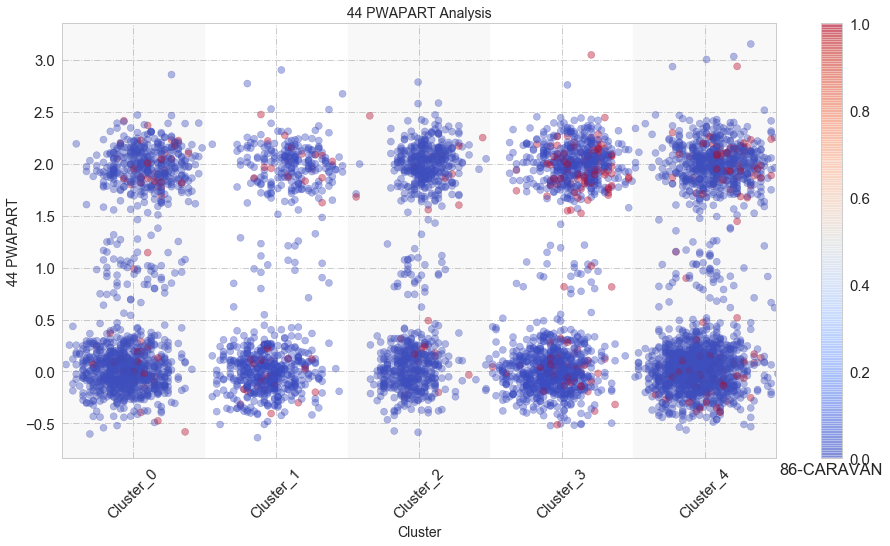

In [72]:
data_44=extract_data(data_ana,43,dis,3)
draw1("44 PWAPART",data_44)

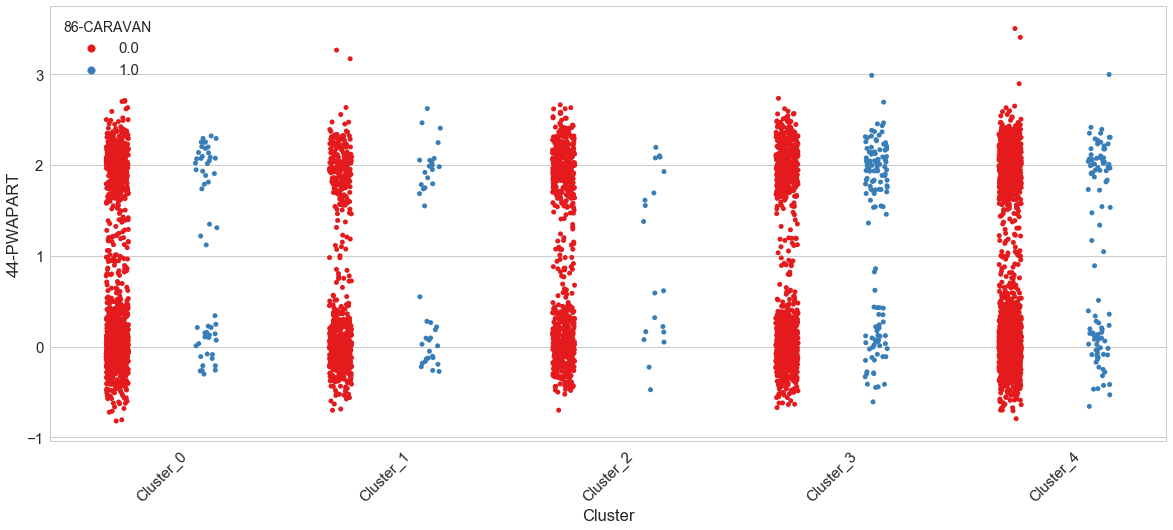

In [73]:
draw2("44-PWAPART",df1)